# Global Trend of Covid-19 Case, Test, and Vaccine Data

*Source: Johns Hopkins University CSSE Covid-19 data* <br />
*Repo: https://github.com/CSSEGISandData/COVID-19*

### Contents

1. Overall time-series in the total number of cases worldwide 
2. Overall trend in testing 
3. Overall trend in vaccinations
4. Changes in the number of cases before and after vaccinations began
5. Country by country case, test, and vaccination analysis


#### Libraries used



In [1]:
import pandas as pd
import numpy as np
import warnings as w

#### Loading the data

In [2]:
#raw data conatiaining time series reported global covid-19 data
cumulative_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

#as data is updated daily, this keeps track of the latest reported data date
last = len(cumulative_data.count()) - 1

#working subset of the data - excluding continent, lat, and long series 
cumulative_data_subset = cumulative_data.iloc[:, 1:last]

#global deaths
global_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

#testing 
testing_data = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/testing/covid-testing-all-observations.csv')

#vaccines
vaccination_data = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv')

The country information is contained within the different data frames. As the vaccination data contains the most complete set of information for each country, I'll create a country dimension by merging it with the global cumulative case data subset created earlier

In [3]:
#countries reporting data
countries = cumulative_data_subset['Country/Region'].drop_duplicates().to_frame()

#adding ISO and merging to one frame
countries_iso = vaccination_data[['location', 'iso_code']].drop_duplicates()

countries_iso = countries_iso.rename(index=str, columns={"location": "Country"})

countries = countries.rename(index=str, columns={"Country/Region": "Country"})

countries = pd.merge(countries, countries_iso, on='Country', how='left')

#add identity/index column
countries["ID"] = countries.index + 1 

I can now merge the country data with the daily reported case count data, and index it



In [4]:
#countries reporting data
countries = cumulative_data_subset['Country/Region'].drop_duplicates().to_frame()

#adding ISO and merging to one frame
countries_iso = vaccination_data[['location', 'iso_code']].drop_duplicates()

countries_iso = countries_iso.rename(index=str, columns={"location": "Country"})

countries = countries.rename(index=str, columns={"Country/Region": "Country"})

countries = pd.merge(countries, countries_iso, on='Country', how='left')

#add identity/index column
countries["ID"] = countries.index + 1 

Completing the dataframes completeness for our global analysis by ensuring they all have country information. This is done by using a left join

In [5]:
w.filterwarnings('ignore')
#merge countries with the case time series data
cumulative_data_subset = cumulative_data_subset.rename(index=str, columns={"Country/Region": "Country"})
merged_covid_cases = pd.merge(cumulative_data_subset, countries, on='Country', how='left')


#vaccination data
vaccination_data_sub = vaccination_data[['location', 'iso_code', 'date', 'total_vaccinations']]
vaccination_data_sub["date"] = pd.to_datetime(vaccination_data_sub["date"])

#merge countries with testing data
testing_data_sub = testing_data[['ISO code', 'Date', 'Cumulative total']]
testing_data_sub = testing_data_sub.rename(index=str, columns={"ISO code": "iso_code", "Date":"date", "Cumulative total": "tests"})
testing_data_sub = pd.merge(testing_data_sub, countries, on='iso_code', how='left')

With the current shape of the data, we cannot aggregate the values by the date, as the dates are series. The data thus needs to be reshaped/unpivoted from this wide format to a long format that will enable this. In order to do this I have used the pandas melt function, using the ID as the identifier column

In [6]:
#don't need these, the aggregation will the global values by date
merged_covid_cases = merged_covid_cases.drop(['Country', 'Lat', 'Long', 'iso_code'], axis=1)

#unpivoting the merged data to get daily case counts
merged_melt = pd.melt(merged_covid_cases, id_vars=['ID']) 

In the long format, the data can then be aggregated by the number of covid cases per day. This is to get the overall global trend of cases over time

In [7]:
#renaming the columns to match data
merged_melt = merged_melt.rename(index=str, columns={"variable": "date", "value": "cases"})

#formating date values to datetype
merged_melt["date"] = pd.to_datetime(merged_melt["date"])#.dt.date
merged_melt["cases"] = pd.to_numeric(merged_melt["cases"])

##sum by date
merged_melt_agg_bydate = merged_melt.drop(['ID'], axis=1)
merged_melt_agg_bydate = merged_melt_agg_bydate.groupby(["date"]).sum().reset_index()


#### Plotting the data!!

In [8]:
%%capture
pip install plotnine

In [9]:
from plotnine import ggplot, aes, geom_line

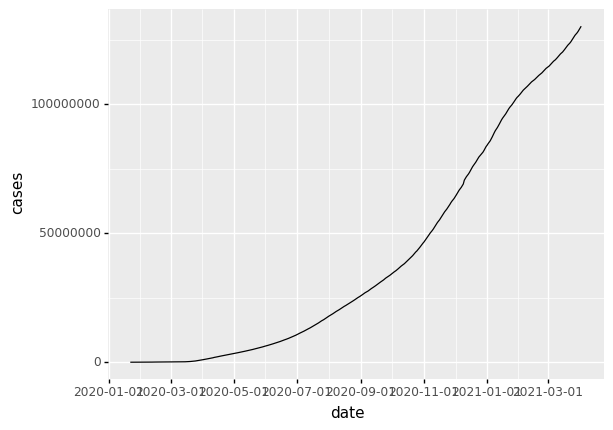

<ggplot: (8762344662260)>

In [10]:
ggplot(merged_melt_agg_bydate) + aes(x="date", y="cases") + geom_line()

This shows there has been an increasing trend in covid-19 cases globally over time. There should be a similar trend for tests as well as vaccines

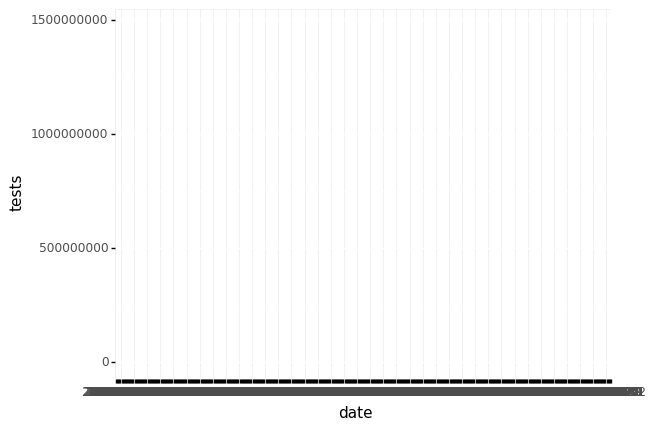

<ggplot: (8762345100692)>

In [15]:
#testing data plot, tests over worldwide
testing_data_agg_date = testing_data_sub[['date', 'tests']].groupby(['date']).sum().reset_index()
ggplot(testing_data_agg_date) + aes(x="date", y="tests") + geom_line()


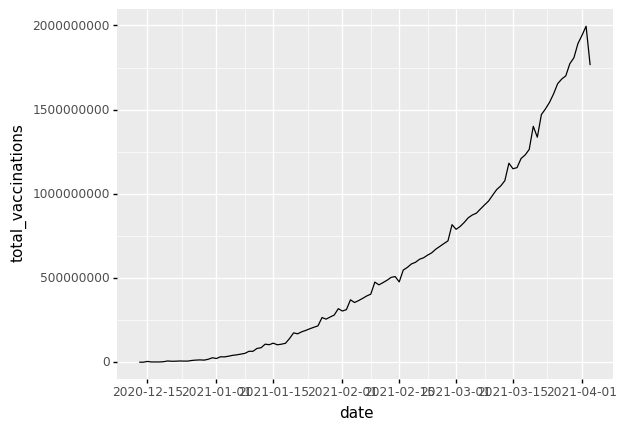

<ggplot: (8762346217027)>

In [16]:
#vaccination data plot, worldwide
vaccination_data_agg_date = vaccination_data_sub[['date', 'total_vaccinations']].groupby(['date']).sum().reset_index()
ggplot(vaccination_data_agg_date) + aes(x="date", y="total_vaccinations") + geom_line()

But which countries contribute the most? A plot of the top 10 countries should show this.

<AxesSubplot:xlabel='Country'>

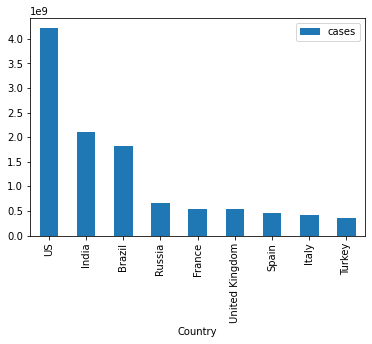

In [11]:
#sum by country - top 10
merged_melt_agg_bycountry = merged_melt.drop(['date'], axis=1)
merged_melt_agg_bycountry = merged_melt_agg_bycountry.groupby(["ID"]).sum().reset_index()
merged_melt_agg_bycountry = merged_melt_agg_bycountry.sort_values(by=['cases'], 
                                                                  ascending=False)
merged_melt_agg_bycountry = pd.merge(merged_melt_agg_bycountry, countries, on='ID', how='left')
merged_melt_agg_bycountry.iloc[0:9, :].plot.bar(x="Country", y="cases")

And are they vaccinating directly proportionally to their case counts?

<AxesSubplot:xlabel='location'>

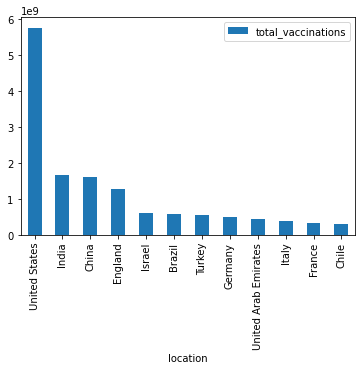

In [17]:
#are top 10 covid countries vacinating proportionally as well
vaccination_data_country = vaccination_data_sub[['location', 'total_vaccinations']].groupby(['location']).sum().reset_index()
#sort
vaccination_data_country = vaccination_data_country.sort_values(by=['total_vaccinations'], ascending=False)
#drop continents
vaccination_data_country = vaccination_data_country.drop(index=[172, 9, 114, 47, 48, 149, 166])
#plot
vaccination_data_country.iloc[0:12, :].plot.bar(x="location", y="total_vaccinations")

Yes they are.

Next, it would be intresting to see if there is an impact in the global trend of cases since vaccinations began. To observe this, we can look at trend of cases before and after the vaccine was introduced

##### Before

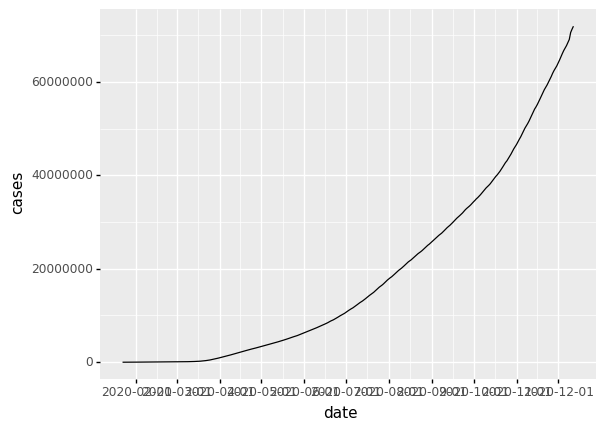

<ggplot: (8762345611632)>

In [19]:
#Cases total before and after vaccine
first_dose_date = vaccination_data_sub["date"].min()

cases_before_vaccine = merged_melt_agg_bydate[merged_melt_agg_bydate.date < first_dose_date]
ggplot(cases_before_vaccine) + aes(x="date", y="cases") + geom_line()



##### After

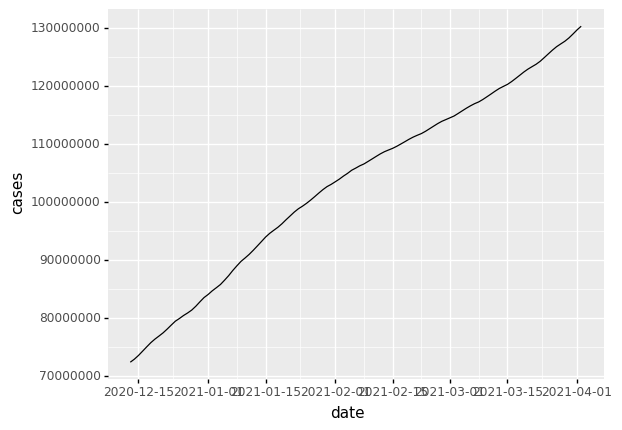

<ggplot: (8762340622653)>

In [20]:
cases_after_vaccine = merged_melt_agg_bydate[merged_melt_agg_bydate.date >= first_dose_date]
ggplot(cases_after_vaccine) + aes(x="date", y="cases") + geom_line()